In [39]:
# -*- coding: utf-8 -*-
import re
import string
import time
import dill

import pickle
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk import collocations
from nltk import ngrams

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
dill.load_session('notebook.db')

In [2]:
emojis = {':)': 'smile', ':-)': 'smile', '8)':'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [3]:
def clean_words(words, stop_words):
    words_clean = []
    ngrams_words_clean = []
    lemmatizer = WordNetLemmatizer()
    for word in words:
        word = word.lower()
        if word not in string.punctuation:
            word = lemmatizer.lemmatize(word)
            ngrams_words_clean.append(word)
            if word not in stop_words:
                words_clean.append(word)

    return words_clean, ngrams_words_clean

In [4]:
def preprocess(textdata):
    stop_words = stopwords.words('english')
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    tweets = []
    all_words_ngrams = []
    for tweet in textdata: 
        # Replace all URls with ''
        tweet = re.sub(urlPattern,'',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, '' + emojis[emoji])        
        # Replace @USERNAME to ''.
        tweet = re.sub(userPattern,'', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, ' ', tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweet = tweet.strip()
        words_for_ngrams = []
        if len(tweet) > 1 and not tweet.isnumeric():    
           # if detect(tweet) == 'en': # Tarda demasiado y no mejora la deteccion de idioma; detecta igualmente el español
            tweet = word_tokenize(tweet)
            tweet, words_for_ngrams = clean_words(tweet,stop_words)
            tweets.append(tweet)
            all_words_ngrams.extend(words_for_ngrams)
        else:
            del tweet

    return tweets, all_words_ngrams

In [5]:
def rightTypes(ngram,stop_words):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stop_words:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [6]:
def rightTypesTri(ngram,stop_words):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stop_words:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False

In [7]:
def bigrams(tweets_words,stop_words):
    bigrams_measures = collocations.BigramAssocMeasures()
    bigram_finder = collocations.BigramCollocationFinder.from_words(tweets_words)
    bigram_freq = bigram_finder.ngram_fd.items()
    
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
    filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x,stop_words))]
    freq_bi = filtered_bi.bigram.values
    return freq_bi

In [8]:
def trigrams(tweets_words,stop_words):
    trigrams_measures = collocations.TrigramAssocMeasures()
    trigram_finder = collocations.TrigramCollocationFinder.from_words(tweets_words)
    trigram_freq = trigram_finder.ngram_fd.items()

    trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
    filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x,stop_words))]
    freq_tri = filtered_tri.trigram.values
    return freq_tri

In [68]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


In [9]:
#       --- IMPORTING DATASET ---
# Using Sentiment140 dataset with 1.6 million tweets
# https://www.kaggle.com/kazanova/sentiment140/data
DATASET_COLUMNS = names = ['sentiment', 'ids', 'date', 'flag', 'user', 'text']
tweets_raw = pd.read_csv(r'.\dataset\tweets.csv', sep = ',', quotechar ='"',encoding='latin-1', names=DATASET_COLUMNS)
tweets_raw['sentiment'] = tweets_raw['sentiment'].replace(4,'pos')
tweets_raw['sentiment'] = tweets_raw['sentiment'].replace(0,'neg')
tweets_raw = list(tweets_raw['text'])

In [10]:
neg_tweets_raw = tweets_raw[:799999]
pos_tweets_raw = tweets_raw[800000:]

In [11]:
t = time.time()
pos_tweets, neg_words_ngrams = preprocess(pos_tweets_raw)
neg_tweets, pos_words_ngrams = preprocess(neg_tweets_raw)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 763 seconds


In [12]:
while len(neg_tweets) > len(pos_tweets):
    del neg_tweets[0]
    del label[-1]
while len(pos_tweets) > len(neg_tweets):
    del pos_tweets[0]
    del label[0]

In [13]:
bgram = bigrams(neg_words_ngrams,stopwords.words('english'))

In [14]:
tgram = trigrams(neg_words_ngrams,stopwords.words('english'))

In [15]:
i = 0
for tweet in pos_tweets:
    sentence = ''
    for word in tweet:
        sentence += word + ' '
    pos_tweets[i] = sentence
    i += 1
i = 0
for tweet in neg_tweets:
    sentence = ''
    for word in tweet:
        sentence += word + ' '
    neg_tweets[i] = sentence
    i += 1

In [16]:
tweets = neg_tweets + pos_tweets

In [17]:
label = []

In [18]:
for i in range(len(tweets)):
    if i < len(neg_tweets):
        label.append('neg')
    else:
        label.append('pos')

In [145]:
X_train, X_test, y_train, y_test = train_test_split(tweets, label, test_size = 0.1, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [146]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


In [147]:
#vectoriser_binary = TfidfVectorizer(ngram_range=(1,2), binary=True, max_features=500000)
#vectoriser_binary.fit(X_train)
#print(f'Vectoriser fitted.')
#print('No. of feature_words: ', len(vectoriser.get_feature_names()))

In [148]:
#X_train_binary = vectoriser_binary.transform(X_train)
#X_test_binary  = vectoriser_binary.transform(X_test)
#print(f'Binary Data Transformed.')

In [149]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [170]:
BNBmodel = BernoulliNB(binarize=0.1)
BNBmodel.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.1, class_prior=None, fit_prior=True)

              precision    recall  f1-score   support

         neg       0.76      0.72      0.74     79695
         pos       0.73      0.77      0.75     79904

    accuracy                           0.74    159599
   macro avg       0.74      0.74      0.74    159599
weighted avg       0.74      0.74      0.74    159599



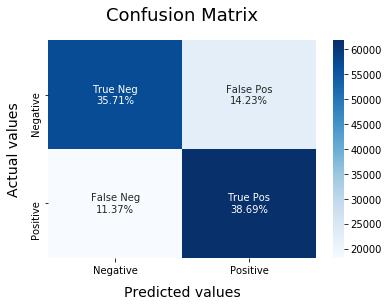

In [169]:
model_Evaluate(BNBmodel)

In [158]:
MNBmodel = MultinomialNB()
MNBmodel.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

              precision    recall  f1-score   support

         neg       0.78      0.78      0.78     79695
         pos       0.78      0.78      0.78     79904

    accuracy                           0.78    159599
   macro avg       0.78      0.78      0.78    159599
weighted avg       0.78      0.78      0.78    159599



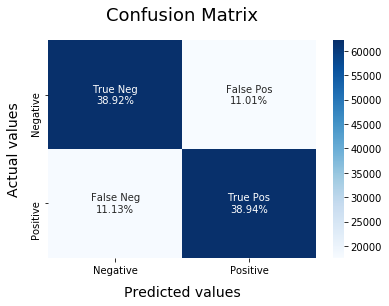

In [159]:
model_Evaluate(MNBmodel)

In [172]:
file = open('.\pickled_algos\Multinomial_NB.pickle','wb')
pickle.dump(MNBmodel, file)
file.close()

file = open('.\pickled_algos\Bernoulli_NB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('.\pickled_algos\Vectoriser.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

In [155]:
dill.dump_session('notebook.db')